In [1]:
#!pip install keras
!pip install tensorflow
!pip3 install opencv-python
import cv2
from tensorflow import keras
import numpy as np
import glob
import tqdm
from tqdm import tqdm

In [2]:
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error
        
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [3]:
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(input)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [4]:
# bonus
class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))
    
    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

In [5]:
# bonus
class SoftmaxLayer:
    def __init__(self, input_size):
        self.input_size = input_size
    
    def forward(self, input):
        self.input = input
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.zeros(output_error.shape)
        out = np.tile(self.output.T, self.input_size)
        return self.output * np.dot(output_error, np.identity(self.input_size) - out)

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def relu_prime(x):
    return np.array(x >= 0).astype('int')

In [7]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size

def sse(y_true, y_pred):
    return 0.5 * np.sum(np.power(y_true - y_pred, 2))

def sse_prime(y_true, y_pred):
    return y_pred - y_true

In [8]:
labels = ['ALL', 'HEM']
dataset_all= glob.glob(r'C:\Users\JahManita\Desktop\Leukemia\2_Dataset\all\*.bmp')
dataset_hem= glob.glob(r'C:\Users\JahManita\Desktop\Leukemia\2_Dataset\hem\*.bmp')

A = []
H = []
A.extend(dataset_all)
H.extend(dataset_hem)
A = np.array(A)
H = np.array(H)
len(A),len(H)

Image = []
Label = []
#Diagonosis label as 1 for ALL
for i in tqdm(range(0, len(A))):
    img = cv2.imread(A[i])
    img = cv2.resize(img, (128,128))
    Image.append(img)
    Label.append(1)
#Diagonosis label as 0 for HEM
for i in tqdm(range(0, len(H))):
    img = cv2.imread(H[i])
    img = cv2.resize(img, (128,128))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

del A
del H

100%|█████████████████████████████████████████████████████████████████████████████| 3389/3389 [00:07<00:00, 439.68it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 711.84it/s]


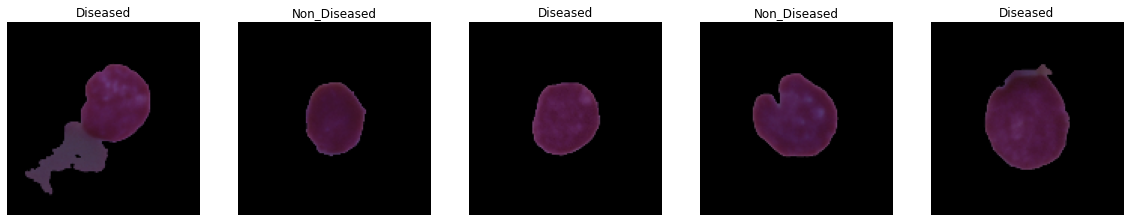

In [9]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Shuffle the data as results are appened.

Image, Label = shuffle(Image, Label, random_state = 42)

# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')
        

In [10]:
#from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

x_train, x_test, y_train, y_test = train_test_split(Image, Label,test_size=0.33, random_state=42)

x_train = x_train.astype('float32')
x_train /= 255
y_train = np_utils.to_categorical(y_train)
x_train = x_train[0:1000]
y_train = y_train[0:1000]

x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_train = x_train[:, :, :, 0]
x_test = x_test[:, :, :, 0]
print(x_train.shape)
print(x_test.shape)

(1000, 128, 128, 3)
(1000, 2)
(3519, 128, 128, 3)
(3519, 2)
(1000, 128, 128)
(3519, 128, 128)


In [12]:
# unlike the Medium article, I am not encapsulating this process in a separate class
# I think it is nice just like this
network = [
    FlattenLayer(input_shape=(128,128)),
    FCLayer(128*128, 128),
    ActivationLayer(relu, relu_prime),
    FCLayer(128, 2),
    SoftmaxLayer(2)
]

epochs = 40
learning_rate = 0.1

# training
for epoch in range(epochs):
    error = 0
    for x, y_true in zip(x_train, y_train):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # error (display purpose only)
        error += mse(y_true, output)

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)
    
    error /= len(x_train)
    print('%d/%d, error=%f' % (epoch + 1, epochs, error))

1/40, error=0.161370
2/40, error=0.150478
3/40, error=0.145144
4/40, error=0.142871
5/40, error=0.140852
6/40, error=0.141828
7/40, error=0.141474
8/40, error=0.140239
9/40, error=0.149785
10/40, error=0.139922
11/40, error=0.137429
12/40, error=0.136261
13/40, error=0.134458
14/40, error=0.132455
15/40, error=0.134060
16/40, error=0.128443
17/40, error=0.132449
18/40, error=0.127271
19/40, error=0.134031
20/40, error=0.126701
21/40, error=0.133208
22/40, error=0.128061
23/40, error=0.126497
24/40, error=0.125586
25/40, error=0.124143
26/40, error=0.122303
27/40, error=0.131981
28/40, error=0.121010
29/40, error=0.124529
30/40, error=0.119045
31/40, error=0.121996
32/40, error=0.120885
33/40, error=0.126479
34/40, error=0.117825
35/40, error=0.117193
36/40, error=0.117811
37/40, error=0.117201
38/40, error=0.122701
39/40, error=0.118606
40/40, error=0.112426


In [13]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

ratio = sum([np.argmax(y) == np.argmax(predict(network, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
error = sum([mse(y, predict(network, x)) for x, y in zip(x_test, y_test)]) / len(x_test)
print('ratio: %.2f' % ratio)
print('mse: %.4f' % error)

ratio: 0.76
mse: 0.1963


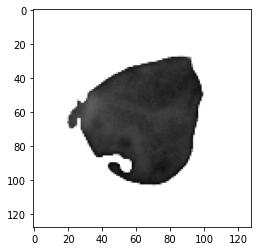

pred: 1, prob: 1.00, true: 1


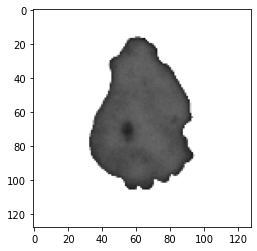

pred: 1, prob: 1.00, true: 1


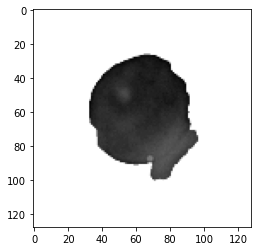

pred: 1, prob: 1.00, true: 1


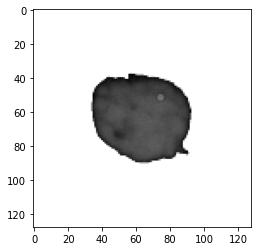

pred: 0, prob: 0.66, true: 0


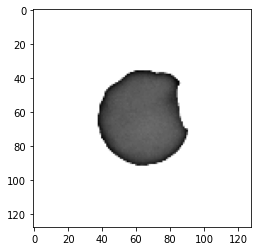

pred: 0, prob: 0.89, true: 1


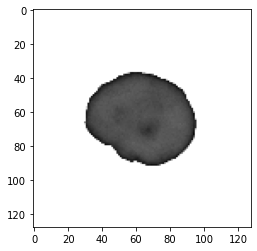

pred: 1, prob: 1.00, true: 1


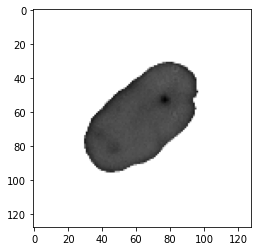

pred: 0, prob: 1.00, true: 1


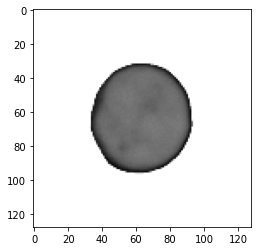

pred: 1, prob: 1.00, true: 1


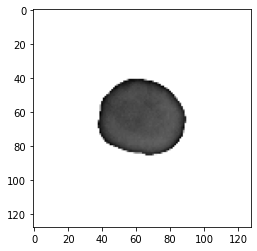

pred: 0, prob: 0.94, true: 0


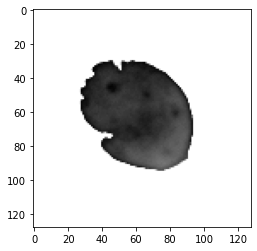

pred: 1, prob: 1.00, true: 1


In [14]:
import matplotlib.pyplot as plt

samples = 10
for test, true in zip(x_test[:samples], y_test[:samples]):
    image = np.reshape(test, (128, 128))
    plt.imshow(image, cmap='binary')
    plt.show()
    pred = predict(network, test)[0]
    idx = np.argmax(pred)
    idx_true = np.argmax(true)
    print('pred: %s, prob: %.2f, true: %d' % (idx, pred[idx], idx_true))